# Hough Transform Crop
DexiNed pretrained edge detection modelinin çıktısı üzerinde Hough Transform ile croplama işlemi

In [1]:
import numpy as np
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
def show(before, after):
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(before, cmap="gray")
    plt.title("Before")
    plt.subplot(122)
    plt.imshow(after, cmap="gray")
    plt.title("After")

#### Hata Çıkanlar
* ../data/drive_10086-back.jpg
* ../data/kimlik2.jpg
* ../data/kimlik4.png
* ../data/kimlik5.jpg

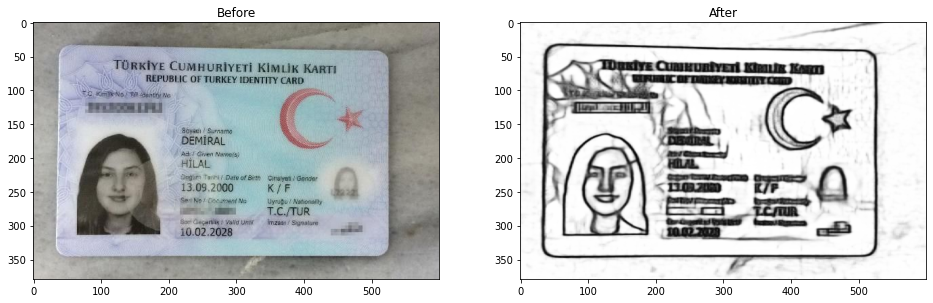

In [3]:
# Görüntülerin okunması
img = cv2.imread("../data/kimlik6.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
edge = cv2.imread("../result/BIPED2CLASSIC/avg/kimlik6.png", 0)
show(img, edge)

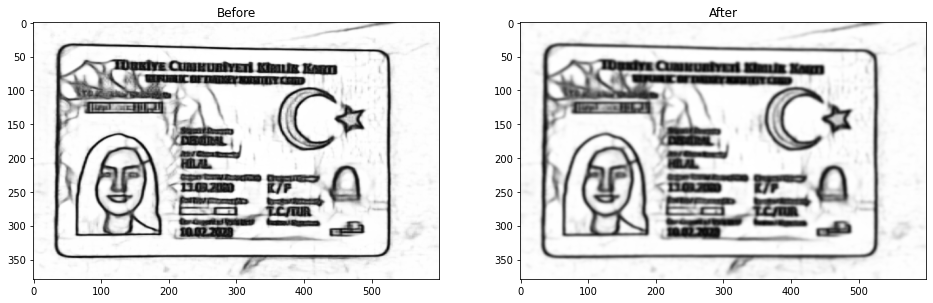

In [4]:
# Gürültü azaltmak için blur
blur = cv2.GaussianBlur(edge, (7,7), 0)
show(edge, blur)

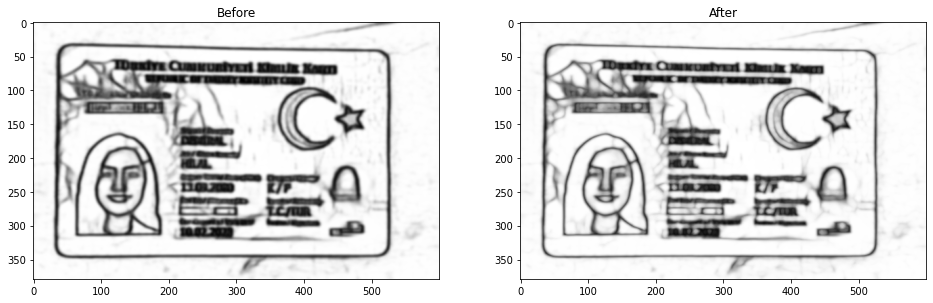

In [5]:
# Dilation ile kenarlar belirginleşiyor
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
dilation = cv2.dilate(blur, kernel, iterations=1)
show(blur, dilation)

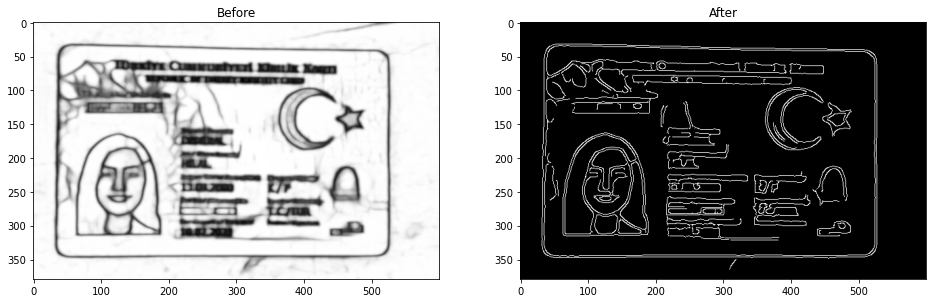

In [6]:
# Canny Edge Detection ile kenar tespiti (Contour yakalama için gerekli)
(mu, sigma) = cv2.meanStdDev(dilation)
canny = cv2.Canny(dilation, (mu[0][0] - sigma[0][0]), (mu[0][0] + sigma[0][0]))
show(dilation, canny)

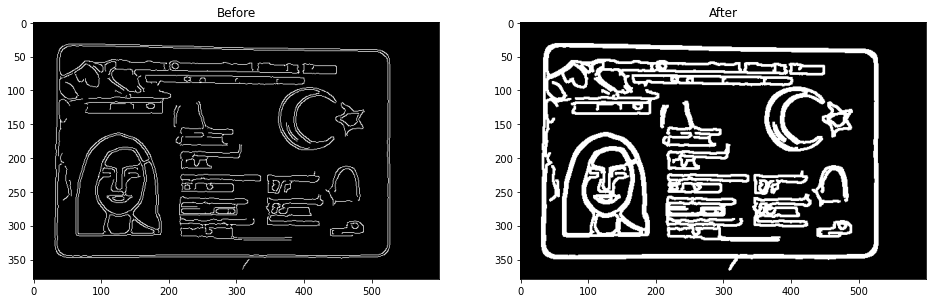

In [7]:
# Dilation ile kenarlar belirginleşiyor, ufak aralıklar kapanıyor
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
dilation2 = cv2.dilate(canny, kernel2, iterations=1)
show(canny, dilation2)

In [8]:
lines = cv2.HoughLines(dilation2, rho=0.75, theta=np.pi / 90, threshold=int((img.shape[0])/2.1))
points = []
if lines is not None:
    for i in range(0, len(lines)):

        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.math.cos(theta)
        b = np.math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 4000*(-b)), int(y0 + 4000*(a)))
        pt2 = (int(x0 - 4000*(-b)), int(y0 - 4000*(a)))
        points.append([pt1,pt2])

In [9]:
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented


def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

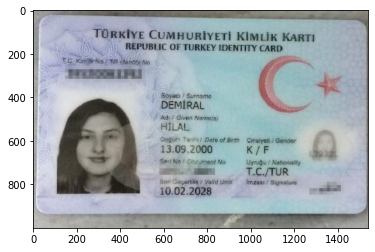

In [10]:
# Segmentation the lines by angle
segmented = segment_by_angle_kmeans(lines)
# Finding the intersections
intersections = segmented_intersections(segmented)
# Finding vertical and horizontal intersection points
vertical = [i[0][0] for i in intersections if i[0][0] > 0]
horizontal = [i[0][1] for i in intersections if i[0][1] > 0]
# Get the min and max points
min_v, max_v, = min(vertical), max(vertical)
min_h, max_h = min(horizontal), max(horizontal)
# Desired size of the image
maxWidth = 1540
maxHeight = 1000
# Perspective crop process
pts1 = np.float32([[min_v, min_h],[max_v, min_h],[min_v, max_h],[max_v, max_h]])
pts2 = np.float32([[0, 0], [maxWidth, 0], [0, maxHeight], [maxWidth, maxHeight]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
croppedImage = cv2.warpPerspective(img, matrix, (maxWidth, maxHeight))
plt.imshow(croppedImage)